# Example: Surface brightness profile extraction and fitting

This thread shows how to read data, extract surface brightness profiles, fit data and extract density profiles with _PyProffit_. 

We start by loading the packages:

In [1]:
import numpy as np
import pyproffit
import matplotlib.pyplot as plt

Then we can move to the data directory with the _os_ package. 

In [2]:
import os

# Change this to the proper directory containing your run
os.chdir('../../validation/')
os.listdir()

['test_sb.fits',
 'gsb.fits',
 'expose_mask_37.fits.gz',
 'test_density.pdf',
 'commands.xcm',
 'test_outmod.fits',
 'test_script.py',
 '.ipynb_checkpoints',
 'test_plot_fit.pdf',
 'test_rec_stan.pdf',
 'reference_depr.fits',
 'test_save_all.fits',
 'pspcb_gain2_256.rsp',
 'b_37.fits.gz',
 'reference_psf.dat',
 'test_dmfilth.fits',
 'Untitled1.ipynb',
 'back_37.fits.gz',
 'reference_pymc3.dat',
 'comp_rec.pdf',
 'test_region.reg',
 'test_mgas.pdf',
 'mybeta_GP.stan',
 'reference_OP.dat',
 'pspcb_gain2_256.fak',
 'Untitled.ipynb',
 'sim.txt']

Now we load the data inside a [Data](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.data.Data) object in PyProffit structure:

In [3]:
dat=pyproffit.Data(imglink='b_37.fits.gz',explink='expose_mask_37.fits.gz',
                   bkglink='back_37.fits.gz')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


1. Here imglink=_'epic-obj-im-700-1200.fits'_ is the link to the image file (count map) to be loaded.
2. The option _explink=_'epic-exp-im-700-1200.fits' allows the user to load an exposure map for vignetting correction. In case this option is left blank, a uniform exposure of 1s is assumed for the observation.   
3. The option _bkglink=_'epic-back-oot-sky-700-1200.fits' allows to load an external background map, which will be used when extracting surface brightness profiles.

The images are then loaded into the [Data](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.data.Data) structure and can be easily accessed as below:

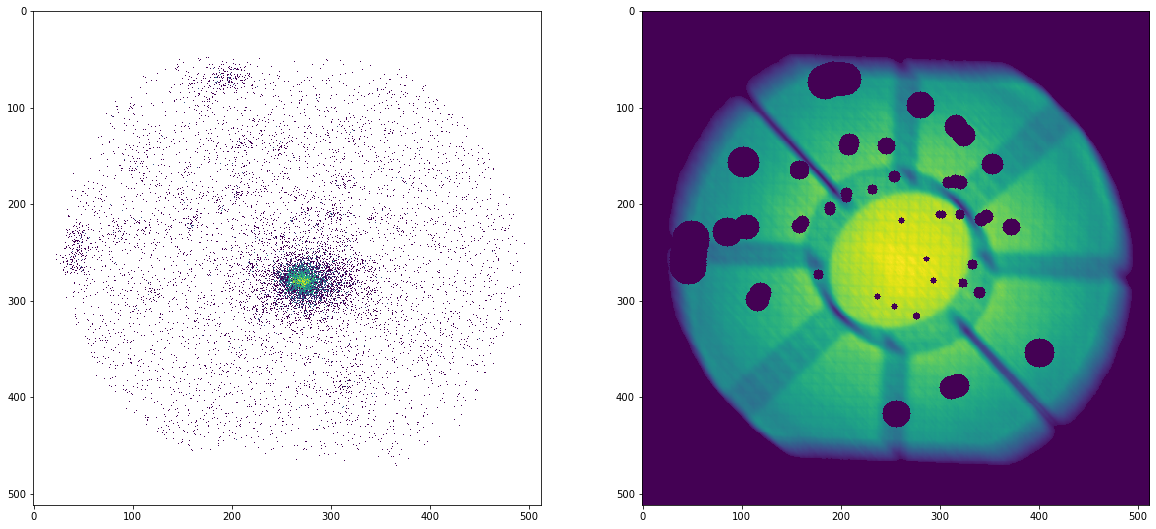

In [4]:
fig = plt.figure(figsize=(20,20))
s1=plt.subplot(221)
plt.imshow(np.log10(dat.img),aspect='auto')
s2=plt.subplot(222)
plt.imshow(dat.exposure,aspect='auto')

All the areas with zero exposure will be automatically excluded. We can ignore additional regions using the [region](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.data.Data.region) method of the [Data](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.data.Data) class, which loads a DS9 region file (in image or FK5 format):

In [5]:
dat.region('../tests/dmfilth.reg')

Excluded 2 sources


The exposure in the requested areas has been set to 0. Let's look at the output:

<Figure size 432x288 with 0 Axes>

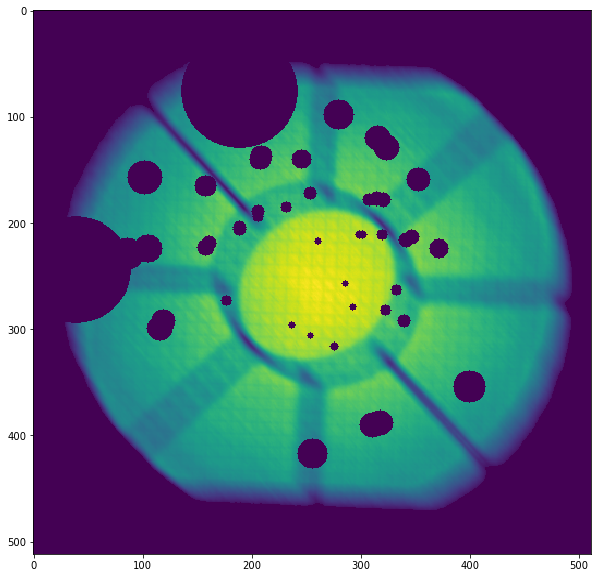

In [6]:
plt.clf()
fig = plt.figure(figsize=(10,10))
plt.imshow(dat.exposure,aspect='auto')

The [Data](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.data.Data) structure also contains the [dmfilth](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.data.Data.dmfilth) method, which can be used to fill the masked areas. The method computes a 2D spline interpolation in between the gaps and generates a Poisson realization of the spline interpolated data, such that the filled holes have similar statistical properties to their surroundings

In [7]:
dat.dmfilth()

Applying high-pass filter
Interpolating in the masked regions
Filling holes


<Figure size 432x288 with 0 Axes>

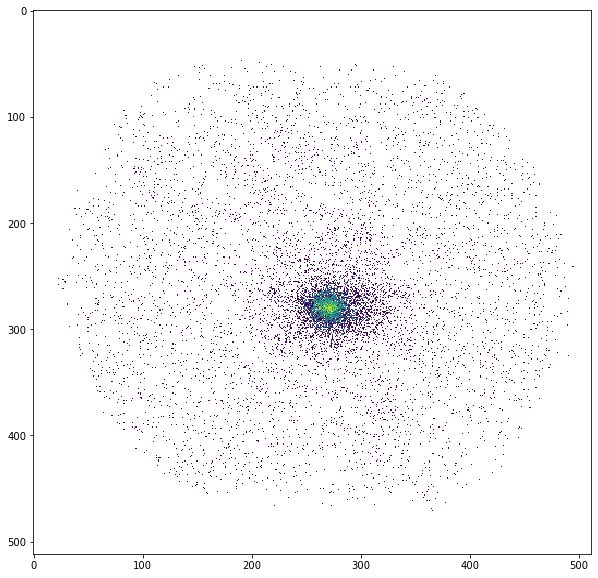

In [8]:
plt.clf()
fig = plt.figure(figsize=(10,10))
plt.imshow(np.log10(dat.filth),aspect='auto')

The image produced by [dmfilth](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.data.Data.dmfilth) is to be compared with the raw image shown above; it is apparent that the sources have been removed and their area has been replaced by a Poisson realization of their interpolated surroundings.

In case a [dmfilth](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.data.Data.dmfilth) image has been generated, the computation of the image centroid and/or of the surface brightness peak to compute the center of the surface brightness profile is done on the [dmfilth](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.data.Data.dmfilth) image rather than on the original image.

## Profile extraction ##

Now we define a [Profile](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.profextract.Profile) object in the following way:


In [9]:
prof=pyproffit.Profile(dat,center_choice='centroid',maxrad=45.,binsize=20.,centroid_region=30.)

Computing centroid and ellipse parameters using principal component analysis
No approximate center provided, will search for the centroid within a radius of 30 arcmin from the center of the image
Denoising image...
Running PCA...
Centroid position: 272.9693463561232 277.500826446281
Corresponding FK5 coordinates:  55.71465074133672 -53.64274857192019
Ellipse axis ratio and position angle: 1.099893588770645 -149.86120200483717


<h3>Profile class options</h3>

The class [Profile](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.profextract.Profile) is designed to contain all the Proffit profile extraction features (not all of them have been implemented yet). The "center_choice" argument specifies the choice of the center:

- center_choice='centroid': compute image centroid and ellipticity 
- center_choice='peak': use brightness peak 
- center_choice='custom_fk5': use custom center in FK5 coordinates (degrees), provided by the "center_ra" and "center_dec" arguments
- center_choice='custom_ima': like custom_fk but with input coordinates in image pixels


The other arguments are the following:

* maxrad: define the maximum radius of the profile (in arcmin)
* binsize: the width of the bins (in arcsec)
* center_ra, center_dec: position of the center (if center_choice='custom_fk5' or 'custom_ima')
* binsize: minimum bin size in arcsec 
* binning=: specify binnig scheme: 'linear' (default), 'log', or 'custom'. In the 'custom' case, an array with the binning definition should be provided through the option bins=array
* centroid_region: for centroid calculation (center_choice='centroid'), optionally provide a radius within which the centroid will be computed, instead of the entire image.


<h3> Now let's extract the profile...</h3>

In [10]:
prof.SBprofile(ellipse_ratio=prof.ellratio,rotation_angle=prof.ellangle+180.)

<p>Here we have extracted a profile in elliptical annuli centered on the image centroid (see above), with an ellipse axis ratio (major/minor) and position angle calculated with principal component analysis. If ellipse_ratio and ellipse_angle are left blank circular annuli are used.</p>

- ellipse_ratio: the ratio of major to minor axis (a/b) of the ellipse (default=1, i.e. circular annuli)
- rotation_angle: rotation angle of the ellipse from the R.A. axis (default=0)
- angle_low, angle_high: in case of profile extraction in sectors, the position angle of the minimum and maximum angles of the sector, with 0 equivalent to the R.A. axis (default=None, i.e. the entire azimuth) 

<p> Now let's plot the profile...</p>

<Figure size 432x288 with 0 Axes>

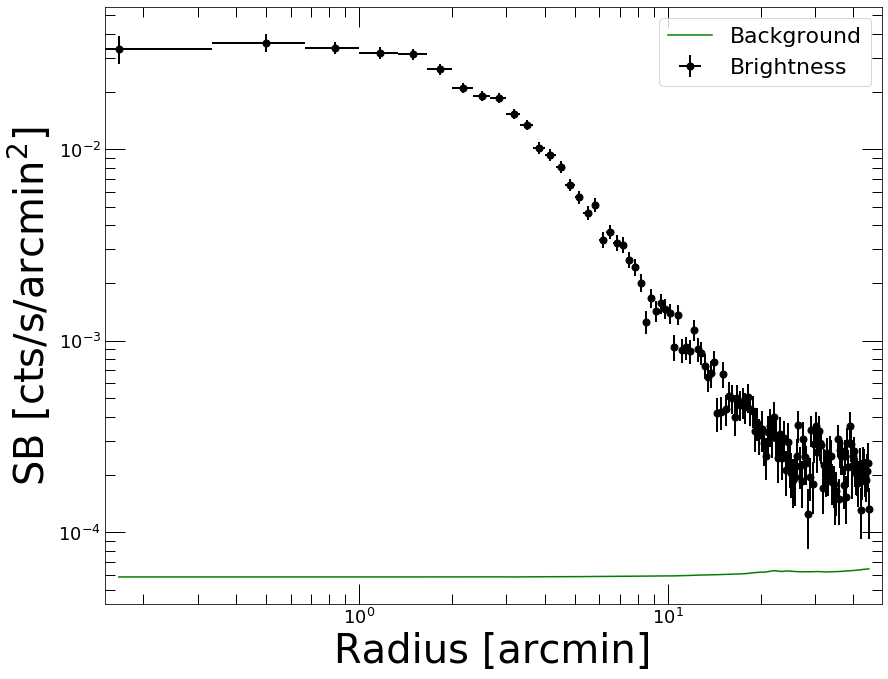

In [11]:
prof.Plot()

## Defining a model ##

Models can be defined using the [Model](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.models.Model) class. PyProffit includes several popular built-in models, however the [Model](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.models.Model) structure is designed to be compatible with any custom Python function (see below)

In [12]:
mod=pyproffit.Model(pyproffit.BetaModel)

To check the parameters of the [BetaModel](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.models.BetaModel) function,

In [13]:
mod.parnames

('beta', 'rc', 'norm', 'bkg')

Any user-defined Python function operating on NumPy arrays can be defined here, see below.

## Fitting the data ##

To fit the extracted profiles PyProffit provides the [Fitter](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.fitting.Fitter) class, which takes a [Profile](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.profextract.Profile) and a [Model](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.models.Model) object as input:

In [14]:
fitobj=pyproffit.Fitter(model=mod, profile=prof)

fitobj.Migrad(beta=0.7,rc=2.,norm=-2,bkg=-4,pedantic=False, fix_beta=True, limit_rc=(0, 10))


------------------------------------------------------------------
| FCN = 148.5                   |     Ncalls=136 (136 total)     |
| EDM = 1.13E-07 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------

Here _beta_ was fixed to its input value through <i>fix_beta=True</i> option, and rc was constrained to be in the region [0,10] through the <i>limit_rc=(0,10)</i> argument.

Now we can plot the data together with the best fitting model

<Figure size 432x288 with 0 Axes>

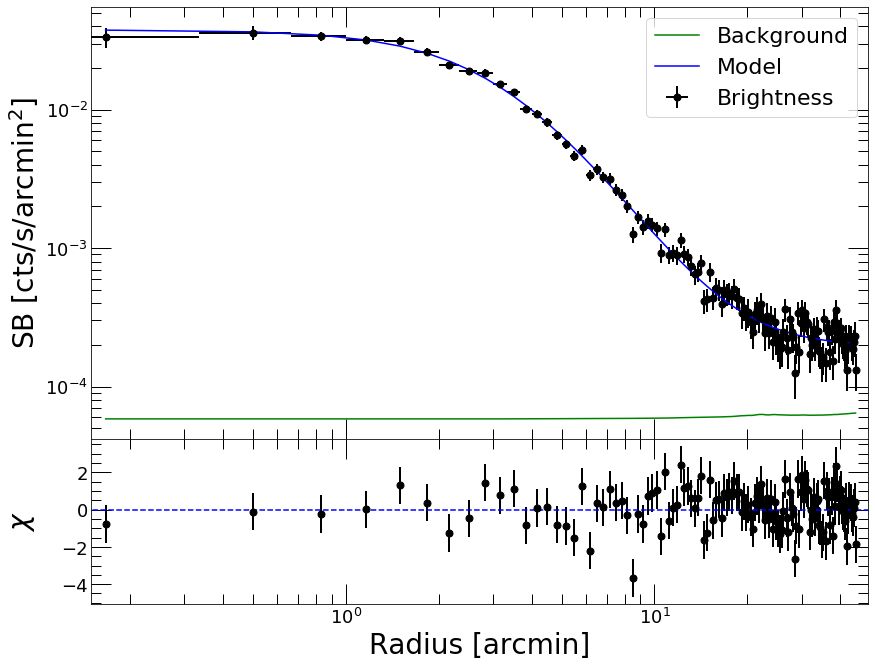

In [15]:
prof.Plot(model=mod)

<p> That's nice; now if instead of $\chi^2$ we want to fit the counts with C-stat</p>

In [16]:
fitobj.Migrad(method='cstat',beta=0.7,rc=2.,norm=-2.,bkg=-4.,pedantic=False,fitlow=0.,fithigh=30.)

------------------------------------------------------------------
| FCN = 91.41                   |     Ncalls=237 (237 total)     |
| EDM = 1.06E-05 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------

Here we have restricted the fitting range to be between 0 and 30 arcmin through the _fitlow_ and _fithigh_ arguments. This time, _beta_ was left free while fitting.

<Figure size 432x288 with 0 Axes>

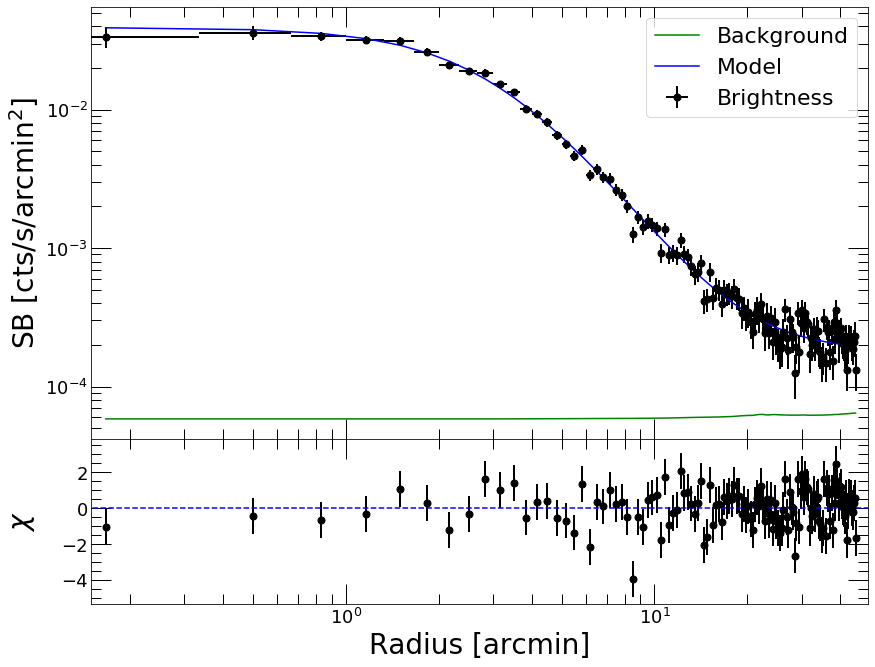

In [17]:
prof.Plot(model=mod)

## Inspecting the results ##

After running _Migrad_ the [Fitter](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.fitting.Fitter) object contains a _minuit_ object which can be used to run all _iminuit_ commands. For instance, we can run _minos_ to get more accurate errors on the parameters:

In [18]:
fitobj.minuit.minos()

-------------------------------------------------
|      beta       |            Valid            |
-------------------------------------------------
|      Error      |    -0.019    |     0.020    |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|       rc        |            Valid            |
-------------------------------------------------
|      Error      |    -0.16     |     0.17     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|      norm       |            Valid            |
-------------------------------------------------
|      Error      |    -0.017    |     0.017    |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|       bkg       |            Valid            |
-------------------------------------------------
|      Error      |    -0.04     |     0.04     |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------

The draw_mncontour method allows to compute parameter covariance plots

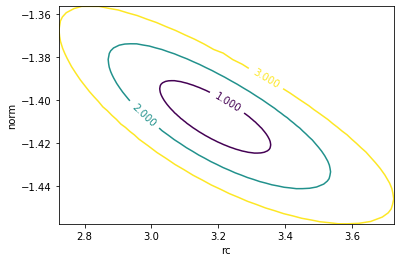

In [19]:
fitobj.minuit.draw_mncontour('rc', 'norm', nsigma=3)

Likelihood profiles for each parameter can be created using the draw_mnprofile method,

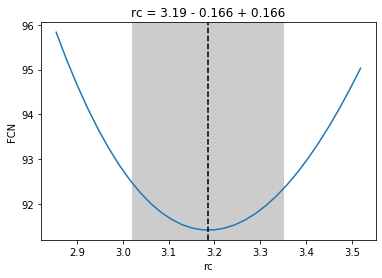

In [20]:
rcval, fcnval = fitobj.minuit.draw_mnprofile('rc')

## Subtracting the background ##

Now if we want to re-extract the profile with a different binning and subtract the background, we can create a new [Profile](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.profextract.Profile) object...

In [21]:
p2=pyproffit.Profile(dat,center_choice='custom_ima',center_ra=prof.cx,center_dec=prof.cy,
                     maxrad=25.,binsize=20.,binning='log')

p2.SBprofile(ellipse_ratio=prof.ellratio,ellipse_angle=prof.ellangle)

Corresponding FK5 coordinates:  55.72164392100449 -53.646907112712


<Figure size 432x288 with 0 Axes>

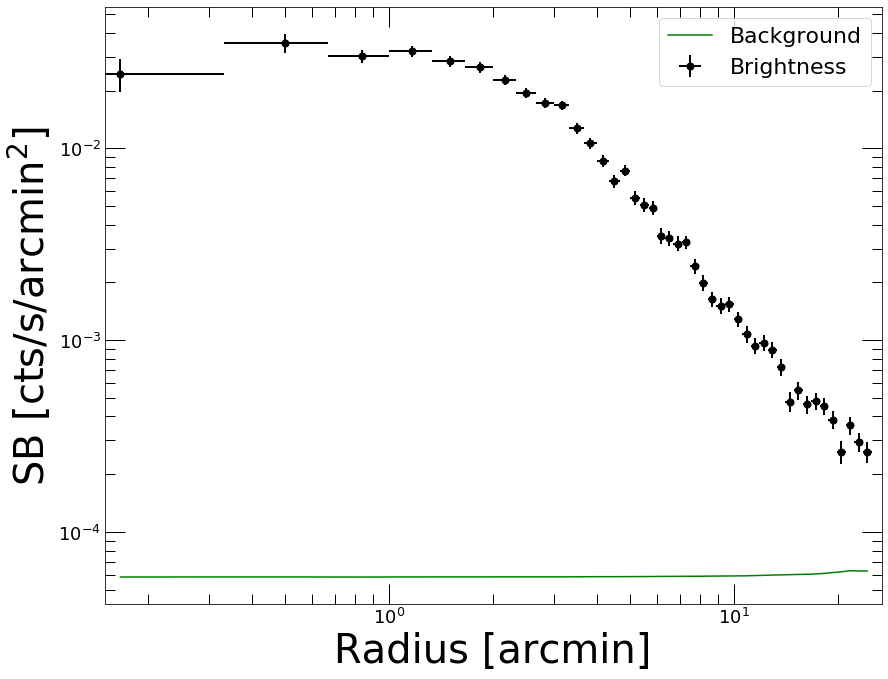

In [22]:
p2.Plot()

We will use the results of the previous fit stored in the [Fitter](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.fitting.Fitter) object to subtract the background. The [Backsub](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.profextract.Profile.Backsub) method of the [Profile](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.profextract.Profile) class reads the _bkg_ parameter, subtracts its value from the brightness profile and adds the statistical error in quadrature:

<Figure size 432x288 with 0 Axes>

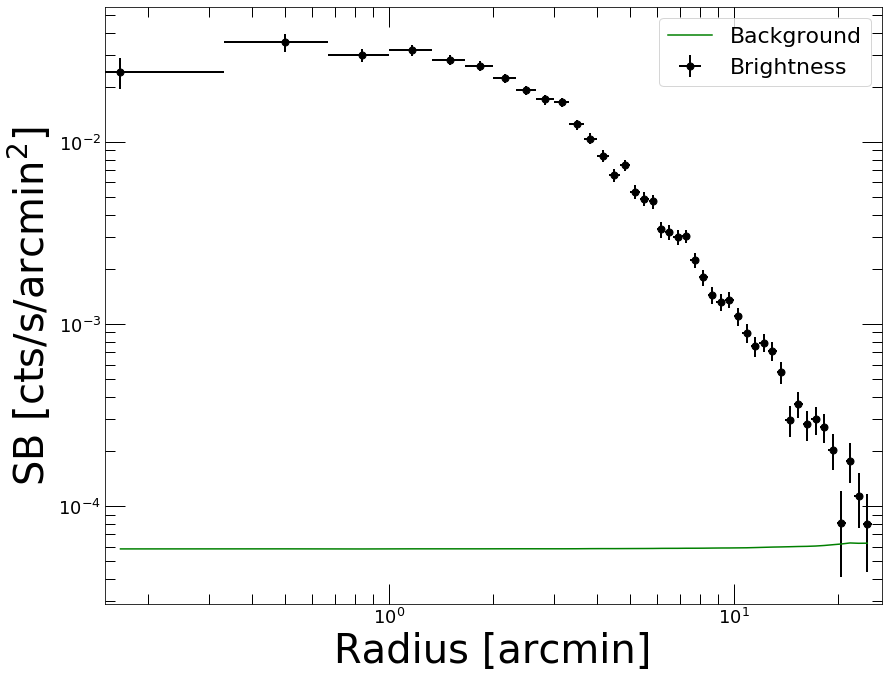

In [23]:
p2.Backsub(fitobj)
p2.Plot()

## Fitting with a custom function ##

To fit the data with any custom function we can simply define a Python function with the desired model and pass it to a PyProffit [Model](https://pyproffit.readthedocs.io/en/latest/pyproffit.html#pyproffit.models.Model) object, with the following structure:

In [24]:
# Create your own model, here some sort of cuspy beta model

def myModel(x,beta,rc,alpha,norm,bkg):
    term1 = np.power(x/rc,-alpha) * np.power(1. + (x/rc) ** 2, -3 * beta + alpha/2.)
    n2 = np.power(10., norm)
    b2 = np.power(10., bkg)
    return n2 * term1 + b2

In [25]:
# Pass the user-defined function to a new Model structure

cuspmod = pyproffit.Model(myModel)

Now we fit the model to the data, as done previously. 

We can also fix the value of some of the parameters to help the convergence. This is done easily with the <i>fix_par=True</i> option, where _par_ is the name of the parameter.

In [26]:
fitvik=pyproffit.Fitter(model=cuspmod, profile=prof)
fitvik.Migrad(beta=0.35, rc=1., alpha=0., norm=-1.7, bkg=-3.8,
              pedantic=False)

------------------------------------------------------------------
| FCN = 143.8                   |     Ncalls=701 (701 total)     |
| EDM = 1.25E-07 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------

<Figure size 432x288 with 0 Axes>

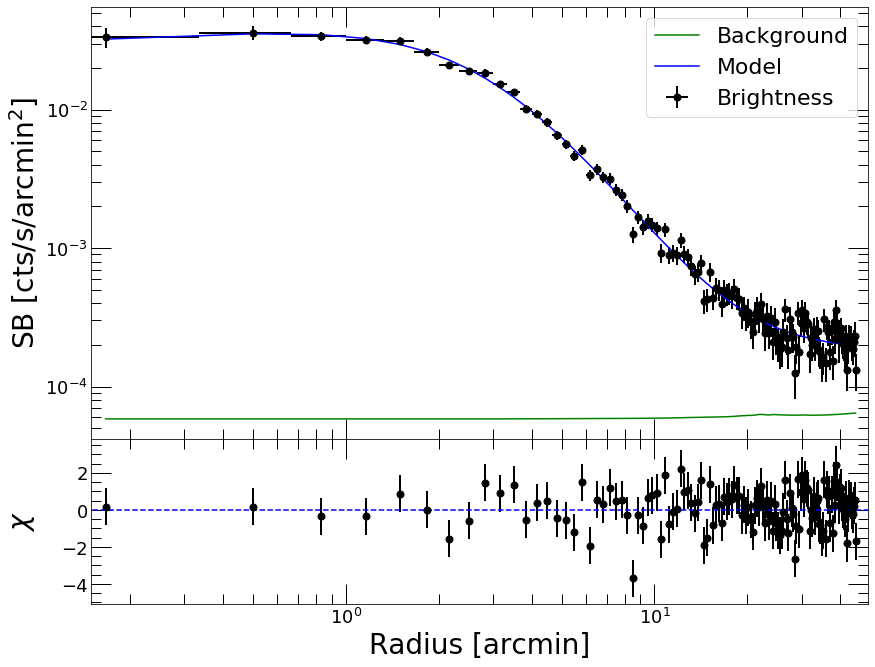

In [27]:
prof.Plot(model=cuspmod)